# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

# 30 lado de mapa, 10000 iteraciones, 0.0001 LR

In [21]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import imageio
from matplotlib import patches as patches
import math as math
import pprint
import os

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [22]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 255
valores_color = 3
num_colores = 100
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores)) 
normalizar_datos = 1#poner 0 o 1

## SOM Setup
#### Variables definidas por el alumno

In [23]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = int(input("Introduzca el lado"))
periodo = int(input("Introduzca el Periodo"))
learning_rate = float(input("Introduzca el Learning Rate"))

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [24]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = 3 #3 por el RGB
num_datos = 256 #de 0 a 255

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2
# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = np.divide((datos), (datos.max()))    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random(size = (lado_mapa, lado_mapa, num_entradas))

#### Funciones para entrenar/clasificar

In [25]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
    distancias = np.linalg.norm(m_pesos - patron_entrada, axis=2)
    bmu_idx = np.unravel_index(np.argmin(distancias), distancias.shape)
    bmu = m_pesos[bmu_idx]
    return bmu, bmu_idx

In [26]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   eta = lr_inicial * (1 - ( i / n_iteraciones))
   return eta

In [27]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   variacion = 1 + vecindario_inicial * (1 - (i / n_iteraciones))
   return variacion

In [28]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU ** 2 / (2 * vecindario_actual ** 2))

In [29]:
def calcular_mse(datos, matriz_pesos, patron):
    """
    Esta función calcula el error cuadrático medio entre los datos y los pesos de la red SOM.
    :param datos: matriz de datos de entrada
    :param matriz_pesos: matriz de pesos de la red SOM
    :return: valor del error cuadrático medio
    """
    # Calcula la BMU
    mse = 0
    bmu_aux, bmu_idx_aux = calcular_bmu(patron, matriz_pesos, num_entradas)
    # Calcula la distancia entre el patrón y la BMU
    distancia = np.sqrt(np.sum((patron - matriz_pesos) ** 2))
    mse += distancia ** 2
    return mse / datos.shape[1]

#### Funciones para dibujar la salida de la red

In [30]:
def pintar_mapa(matriz_valores, cont):
    fig = plt.figure()

    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor = matriz_valores[x-1,y-1, :],
                         edgecolor = 'none'))
    
    plt.savefig(f'Evolucion/imagen{cont}.png')
    plt.show()

### Función pintar la variación del learning rate

In [31]:
def plot_learning_rate(lrate):
    """
    Esta función grafica la variación del learning rate en cada iteración.
    :param lrate: una lista de valores de learning rate en cada iteración
    """
    # Crear la figura
    fig, ax = plt.subplots()

    # Crear el gráfico de línea
    ax.plot(lrate, label='Learning rate')

    # Añadir etiquetas y título
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Valor del learning rate')
    ax.set_title('Variación del learning rate')

    # Mostrar la leyenda y el gráfico
    ax.legend()
    plt.show()

### Función pintar la curva de aprendizaje

In [32]:
def plot_curva_aprendizaje(mse):
    """
    Función que grafica la curva de aprendizaje de un SOM.

    Args:
    mse: ndarray, array que contiene el error cuadrático medio por época.
    """
    plt.plot(range(len(mse)), mse)
    plt.title('Curva de aprendizaje')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.show()

### Video de Animación de la red SOM

In [33]:
def animacion(cont):
    with imageio.get_writer('Evolucion/animacion.mp4', fps=30) as writer:
        for i in range(cont):
            filename = f'Evolucion/imagen{i}.png'
            image = imageio.imread(filename)
            writer.append_data(image)

## SOM Entrenamiento

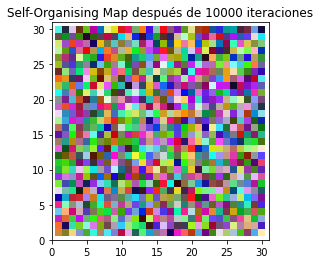

Iteración 0/10000


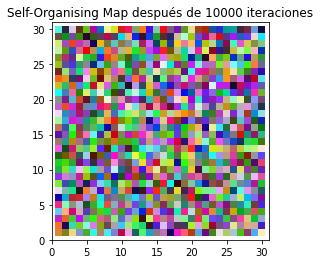

Iteración 100/10000


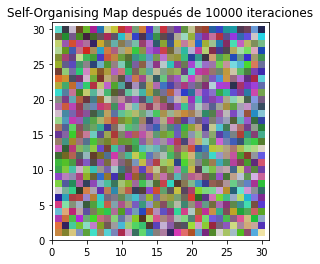

Iteración 200/10000


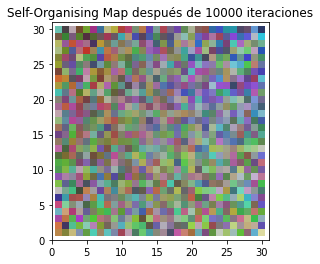

Iteración 300/10000


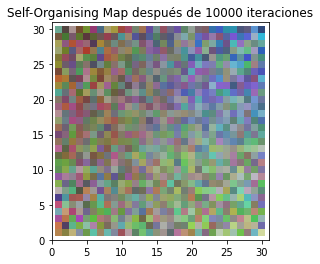

Iteración 400/10000


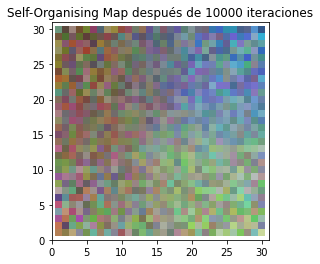

Iteración 500/10000


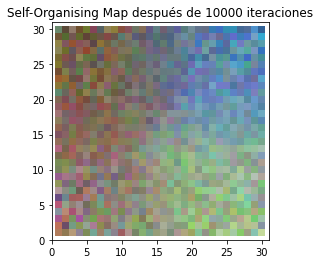

Iteración 600/10000


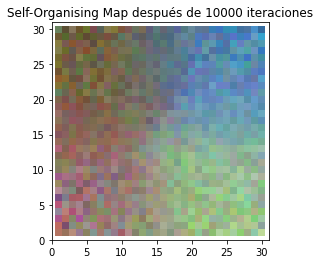

Iteración 700/10000


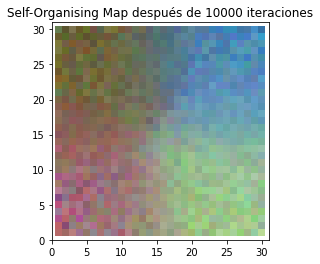

Iteración 800/10000


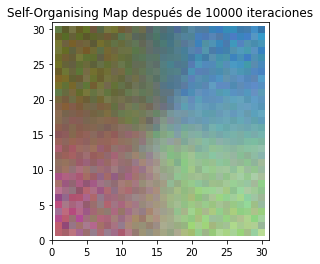

Iteración 900/10000


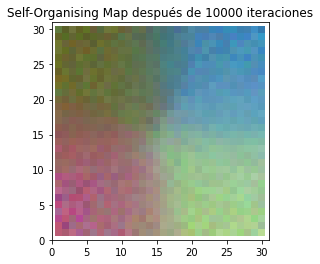

Iteración 1000/10000


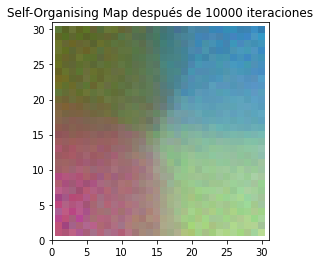

Iteración 1100/10000


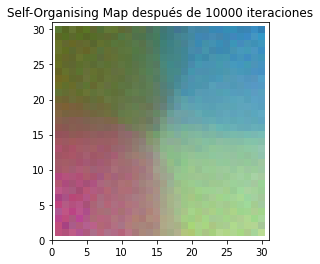

Iteración 1200/10000


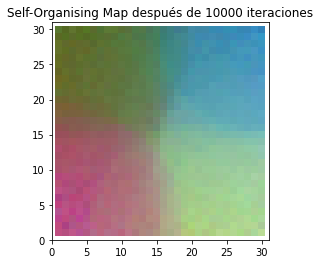

Iteración 1300/10000


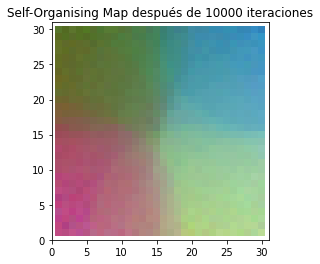

Iteración 1400/10000


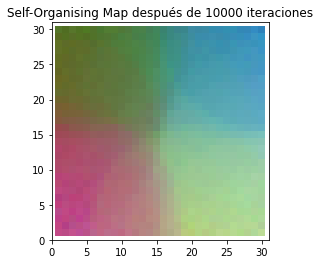

Iteración 1500/10000


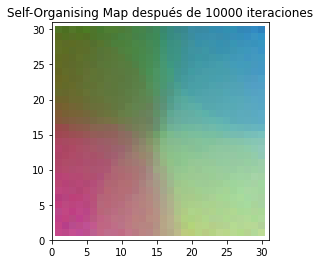

Iteración 1600/10000


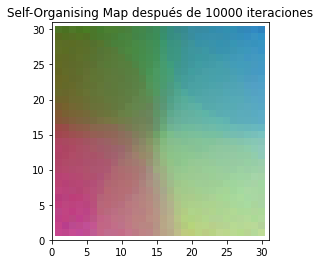

Iteración 1700/10000


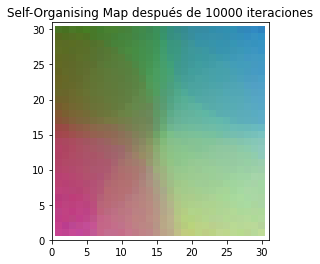

Iteración 1800/10000


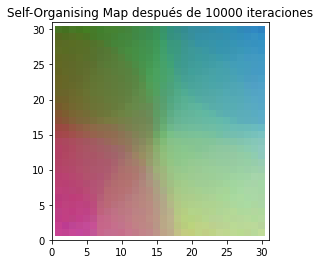

Iteración 1900/10000


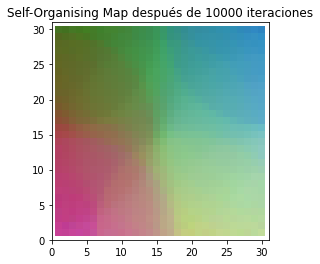

Iteración 2000/10000


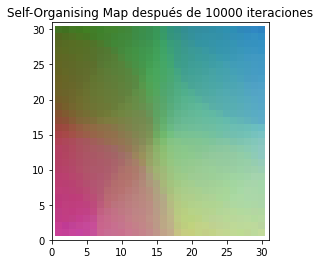

Iteración 2100/10000


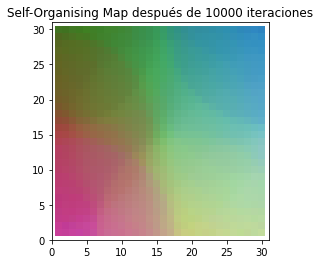

Iteración 2200/10000


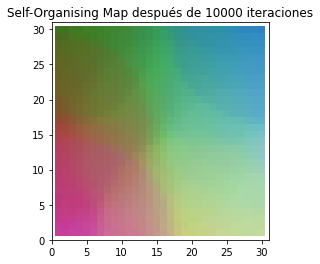

Iteración 2300/10000


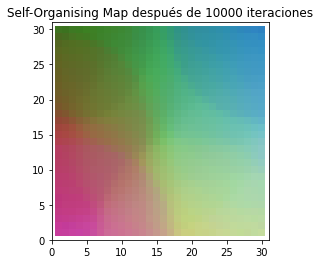

Iteración 2400/10000


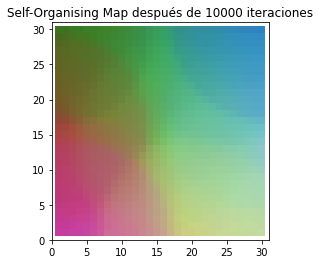

Iteración 2500/10000


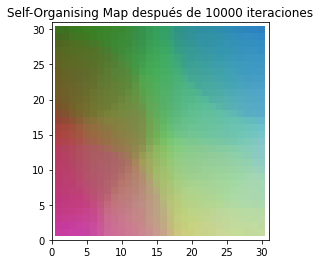

Iteración 2600/10000


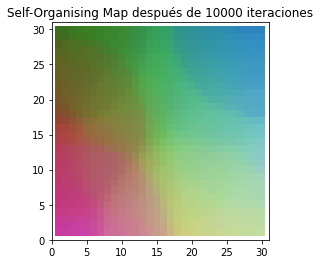

Iteración 2700/10000


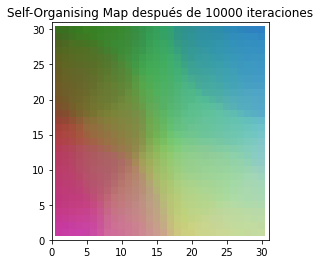

Iteración 2800/10000


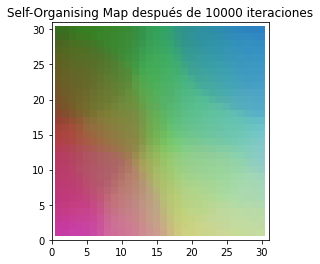

Iteración 2900/10000


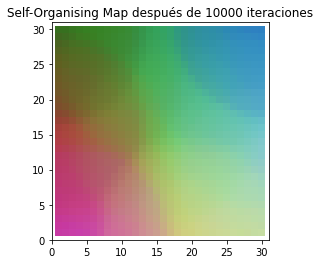

Iteración 3000/10000


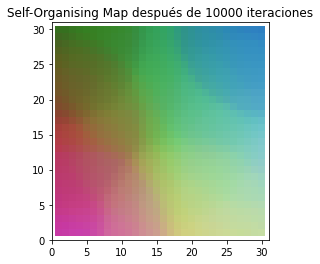

Iteración 3100/10000


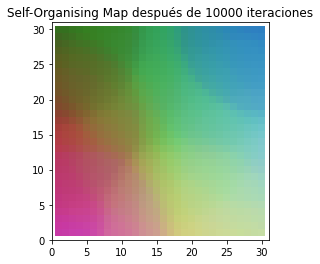

Iteración 3200/10000


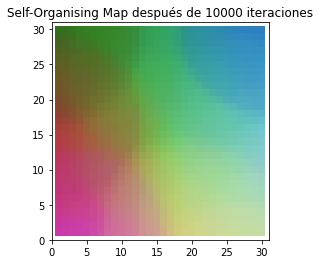

Iteración 3300/10000


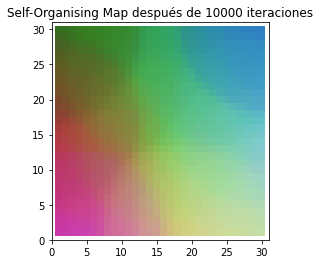

Iteración 3400/10000


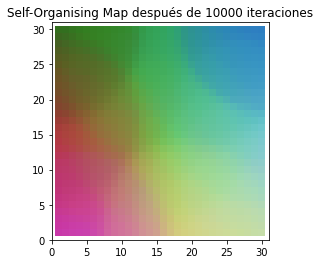

Iteración 3500/10000


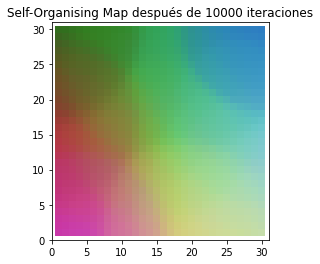

Iteración 3600/10000


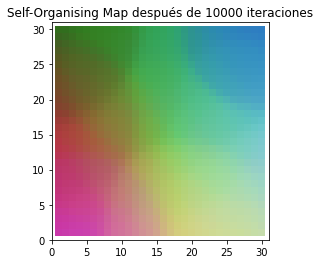

Iteración 3700/10000


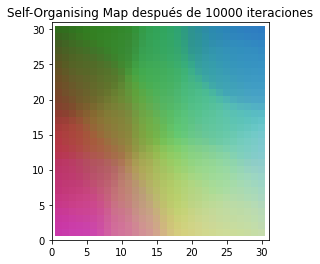

Iteración 3800/10000


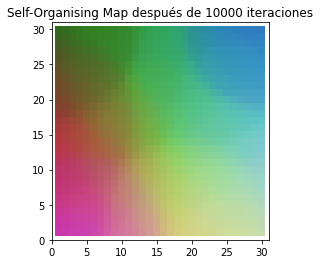

Iteración 3900/10000


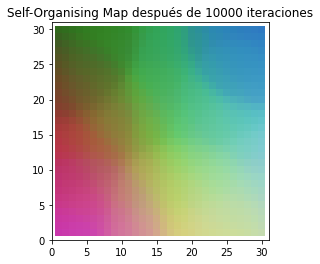

Iteración 4000/10000


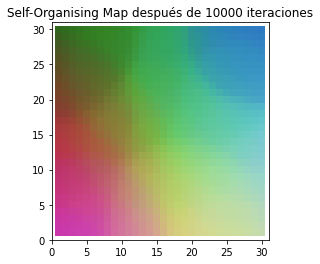

Iteración 4100/10000


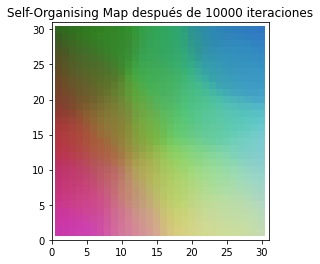

Iteración 4200/10000


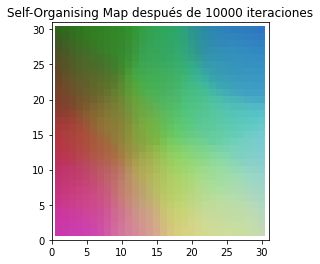

Iteración 4300/10000


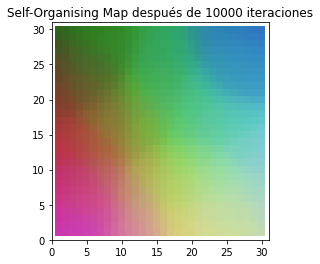

Iteración 4400/10000


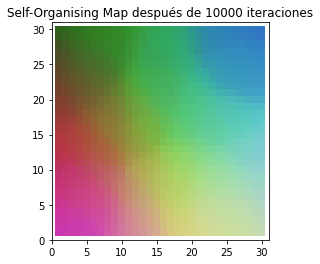

Iteración 4500/10000


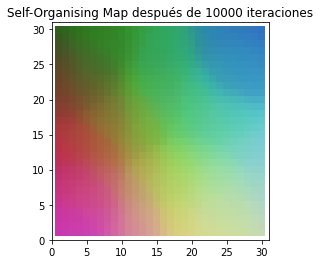

Iteración 4600/10000


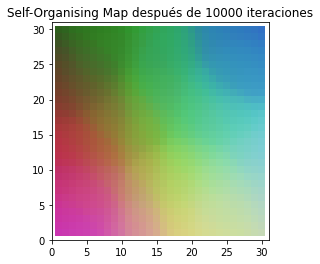

Iteración 4700/10000


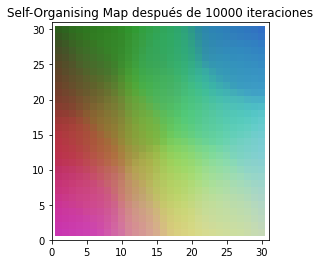

Iteración 4800/10000


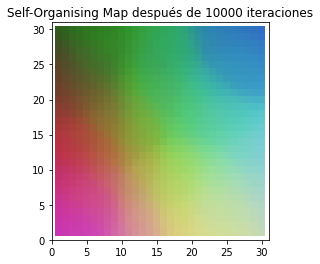

Iteración 4900/10000


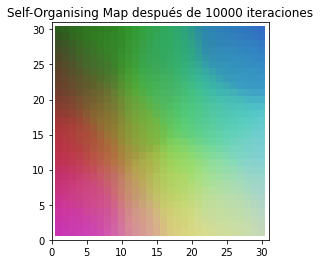

Iteración 5000/10000


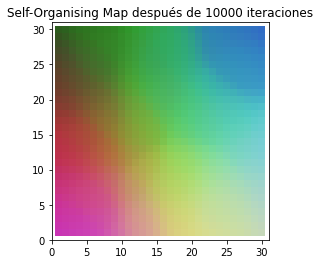

Iteración 5100/10000


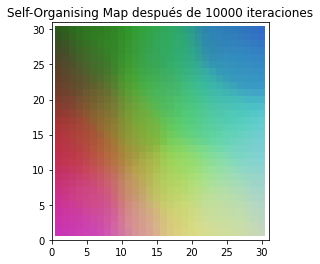

Iteración 5200/10000


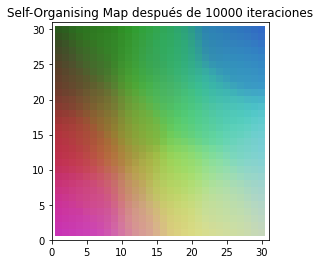

Iteración 5300/10000


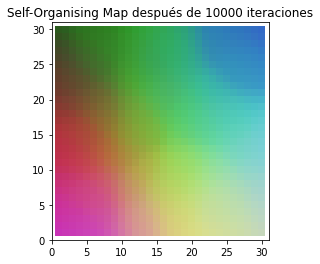

Iteración 5400/10000


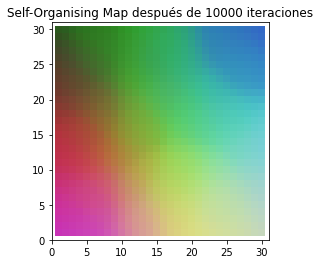

Iteración 5500/10000


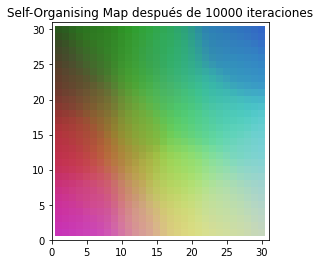

Iteración 5600/10000


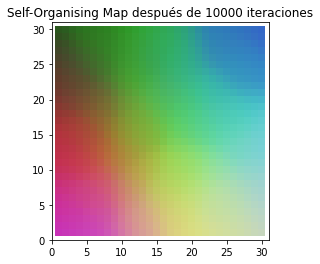

Iteración 5700/10000


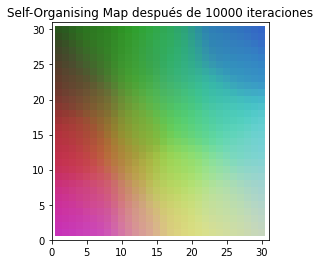

Iteración 5800/10000


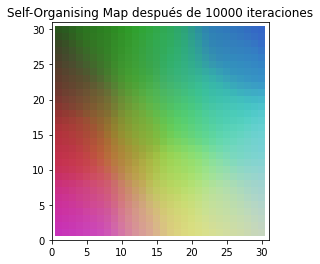

Iteración 5900/10000


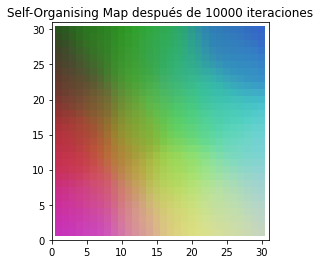

Iteración 6000/10000


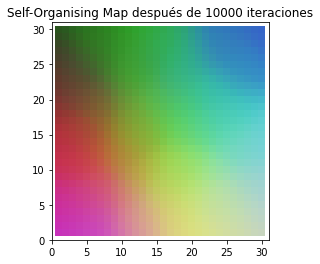

Iteración 6100/10000


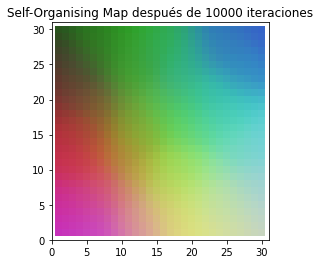

Iteración 6200/10000


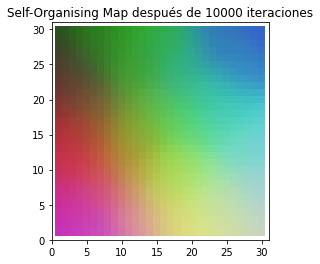

Iteración 6300/10000


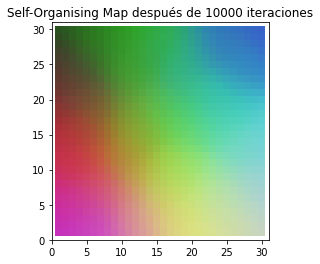

Iteración 6400/10000


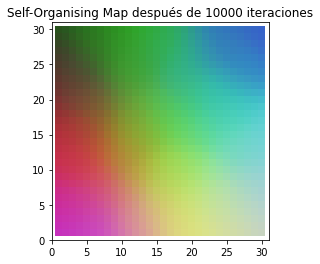

Iteración 6500/10000


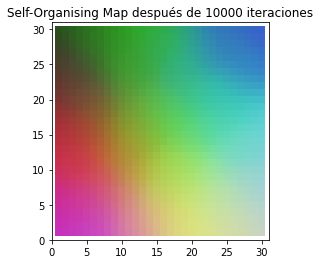

Iteración 6600/10000


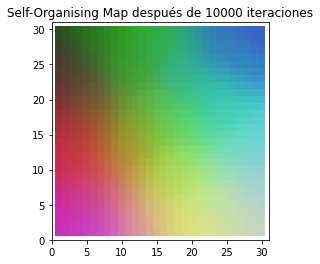

Iteración 6700/10000


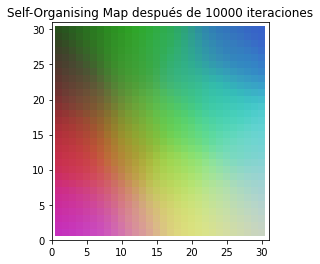

Iteración 6800/10000


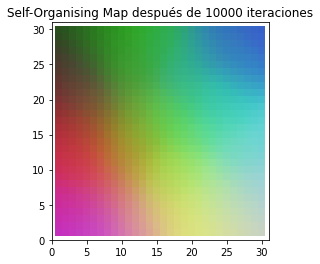

Iteración 6900/10000


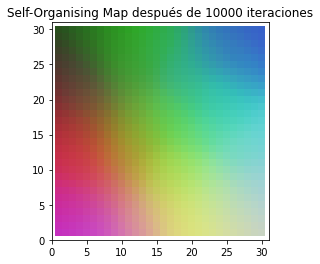

Iteración 7000/10000


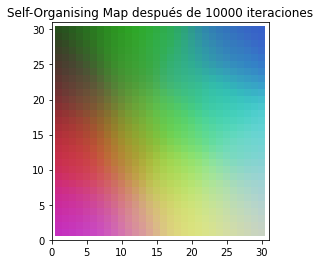

Iteración 7100/10000


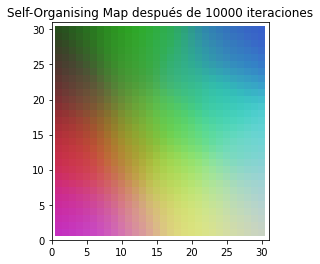

Iteración 7200/10000


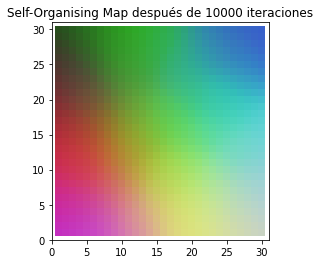

Iteración 7300/10000


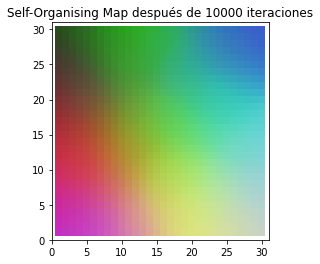

Iteración 7400/10000


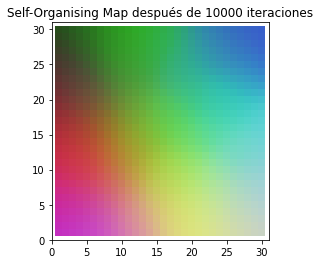

Iteración 7500/10000


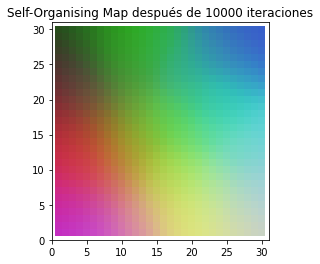

Iteración 7600/10000


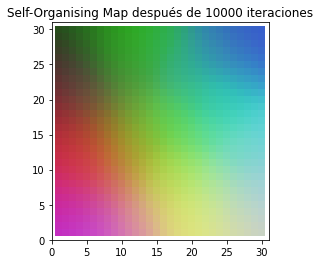

Iteración 7700/10000


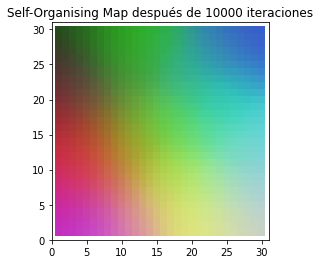

Iteración 7800/10000


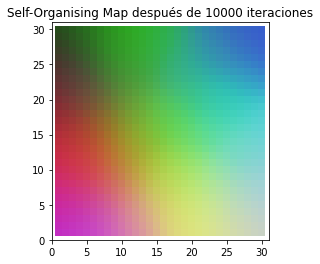

Iteración 7900/10000


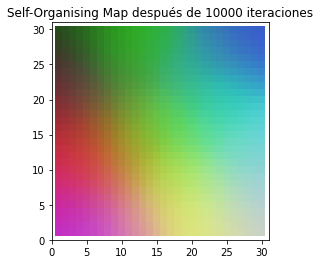

Iteración 8000/10000


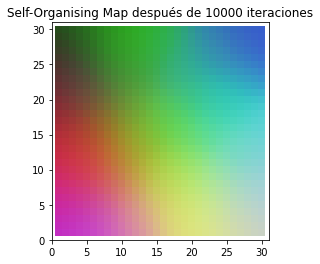

Iteración 8100/10000


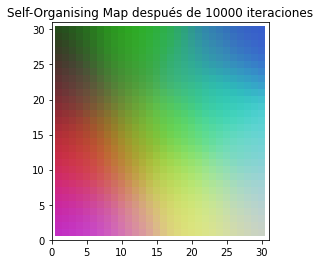

Iteración 8200/10000


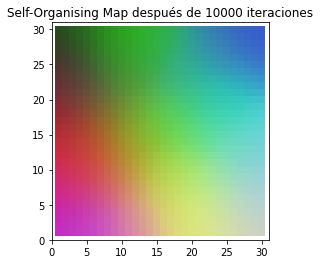

Iteración 8300/10000


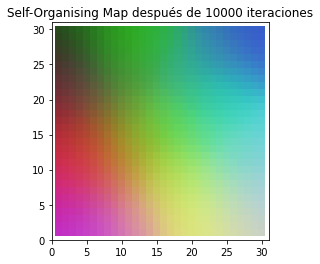

Iteración 8400/10000


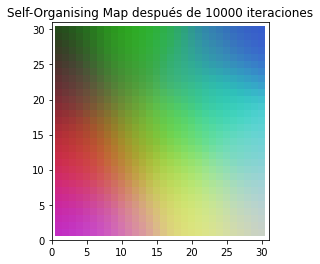

Iteración 8500/10000


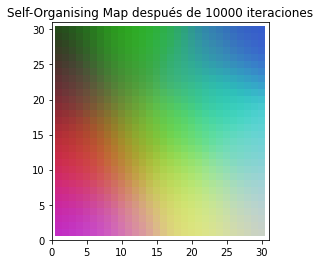

Iteración 8600/10000


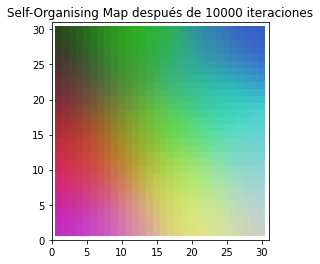

Iteración 8700/10000


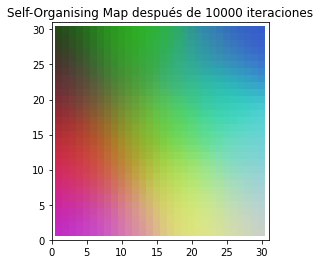

Iteración 8800/10000


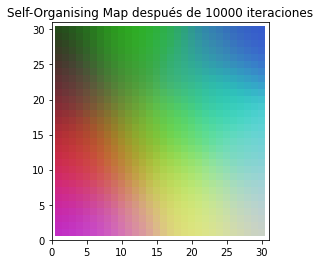

Iteración 8900/10000


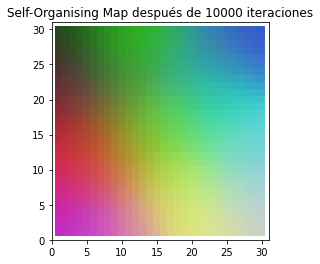

Iteración 9000/10000


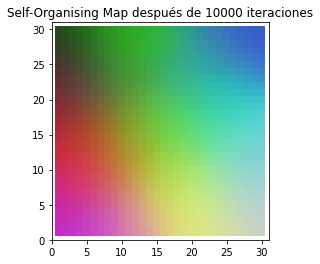

Iteración 9100/10000


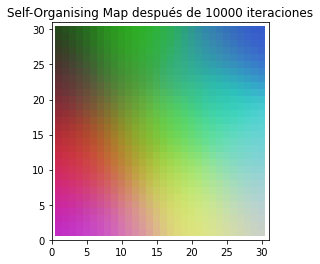

Iteración 9200/10000


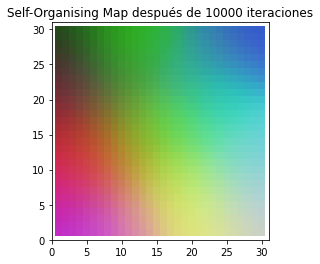

Iteración 9300/10000


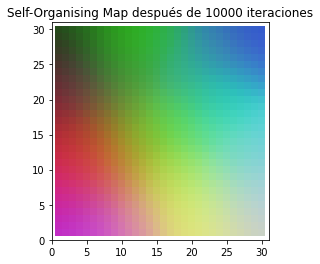

Iteración 9400/10000


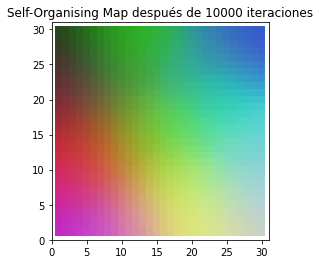

Iteración 9500/10000


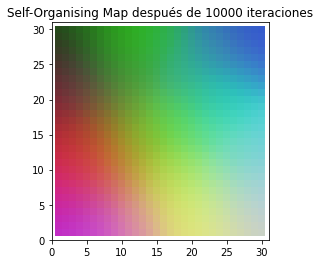

Iteración 9600/10000


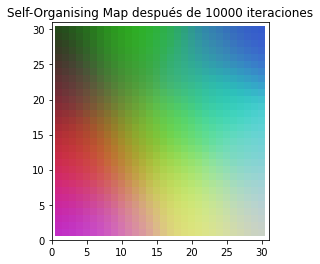

Iteración 9700/10000


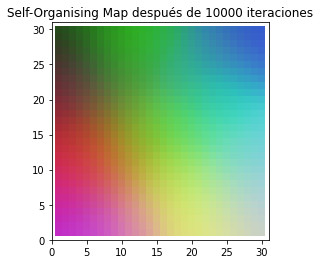

Iteración 9800/10000


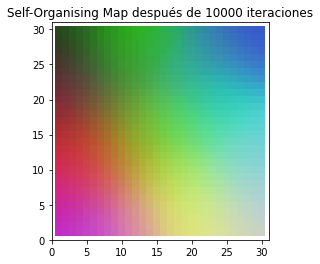

Iteración 9900/10000


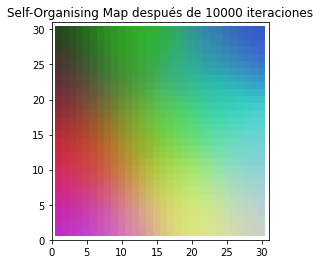

Entrenamiento finalizado


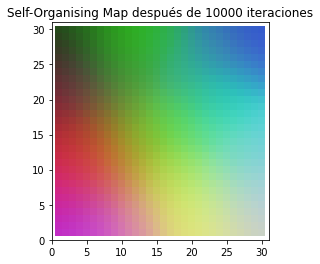

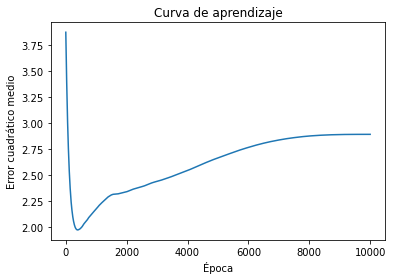

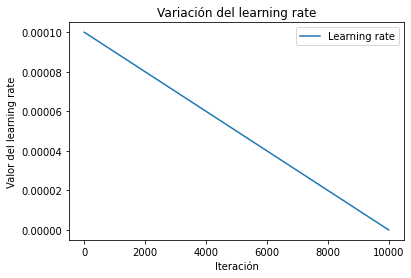

In [34]:
# Entrena la red con el dataset de entrenamiento
cont = 0
mse = []
if(os.path.exists("Evolucion")) == 0:
    os.mkdir("Evolucion")
etahistoricos = np.zeros(periodo)
pintar_mapa(matriz_pesos, cont)
for i in range(periodo):
    for patron in datos.T:
        # Calcula la BMU
        bmu, bmu_idx = calcular_bmu(patron, matriz_pesos, num_entradas)
        # Calcula el descenso del coeficiente de aprendizaje y del vecindario
        eta = variacion_learning_rate(learning_rate, i, periodo)
        etahistoricos[i] = eta
        v = variacion_vecindario(vecindario, i, periodo)
        # Actualiza los pesos de las neuronas
        for x in range(matriz_pesos.shape[0]):
            for y in range(matriz_pesos.shape[1]):
                w = matriz_pesos[x, y, :]
                distancia = np.sqrt(np.sum((np.array([x, y]) - np.array(bmu_idx)) ** 2))
                if distancia <= v:
                    # Calcula la amortiguación de eta
                    amortiguacion = decay(distancia, v)
                    # Actualiza los pesos
                    matriz_pesos[x, y, :] = w + (eta * amortiguacion * (patron - w))
    mse.append(calcular_mse(datos, matriz_pesos, patron))
    if i % 100 == 0:
        print('Iteración %d/%d' % (i, periodo))
        cont += 1
        pintar_mapa(matriz_pesos, cont)

print('Entrenamiento finalizado')
pintar_mapa(matriz_pesos, cont)
plot_curva_aprendizaje(mse)
plot_learning_rate(etahistoricos)

### Creación del Vídeo

In [35]:
animacion(cont)

C:\Users\kinde\AppData\Local\Temp\ipykernel_31348\2203658977.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## SOM Clasificación

In [36]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
# Definir y inicializar las matrices
mapa_clasificacion = np.zeros(matriz_pesos.shape)
mapa_activaciones = np.zeros((lado_mapa, lado_mapa))
mapa_distancias = np.zeros((lado_mapa, lado_mapa))

# Recorrer todo el dataset de entrenamiento
for patron_entrada in datos.T: # Obtener el patrón de entrada
        # Calcular la BMU y sus coordenadas
        bmu, bmu_idx = calcular_bmu(patron_entrada, matriz_pesos, num_entradas)
        bmu_x, bmu_y = bmu_idx

        # Imprimir las coordenadas de la BMU
        print("Patrón {}: BMU en ({}, {})".format(patron_entrada, bmu_x, bmu_y))

        # Actualizar los mapas de clasificación, activaciones y distancias
        mapa_clasificacion[bmu_x, bmu_y] = patron_entrada      
        mapa_activaciones[bmu_x, bmu_y] += 1
    
        #mapa_activaciones[bmu_x, bmu_y] = num_activ
        #mapa_distancias[bmu_x, bmu_y] += np.linalg.norm(patron_entrada - matriz_pesos[bmu_x, bmu_y])
        mapa_distancias[bmu_x, bmu_y] += np.mean(np.linalg.norm(patron_entrada - matriz_pesos[bmu_x, bmu_y])) 
# Calcular el número de clases
num_clases = len(np.unique(mapa_clasificacion))
# Calcular la distancia media y el Error Topológico del mapa
error_cuantificacion = np.mean(np.linalg.norm(matriz_pesos - mapa_clasificacion, axis=2)) / num_entradas

error_topologico = 0
for x in range(lado_mapa):
    for y in range(lado_mapa):
        vecinos = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (i >= 0 and i < lado_mapa and j >= 0 and j < lado_mapa)]
        vecinos_activos = [v for v in vecinos if mapa_activaciones[v] > 0]
        if vecinos_activos:
            vecinos_distancias = [np.linalg.norm(matriz_pesos[x, y] - matriz_pesos[i, j]) for (i, j) in vecinos_activos]
max_distancia = np.nanmax(vecinos_distancias)
min_distancia = np.nanmin(vecinos_distancias)
if min_distancia > 0:
    error_topologico += max_distancia / min_distancia


Patrón [0.09090909 0.03162055 0.03162055]: BMU en (0, 27)
Patrón [0.52964427 0.46640316 0.94071146]: BMU en (29, 25)
Patrón [0.88932806 0.7826087  0.97233202]: BMU en (29, 2)
Patrón [0.15019763 0.41501976 0.36758893]: BMU en (5, 24)
Patrón [0.97628458 0.96442688 0.40316206]: BMU en (19, 0)
Patrón [0.2055336  0.79841897 0.09486166]: BMU en (11, 29)
Patrón [0.43083004 0.68774704 0.91304348]: BMU en (29, 13)
Patrón [0.04347826 0.33201581 0.80632411]: BMU en (29, 29)
Patrón [0.27272727 0.98023715 0.71146245]: BMU en (24, 15)
Patrón [0.70355731 0.11462451 0.08695652]: BMU en (0, 14)
Patrón [0.81027668 0.38735178 0.02766798]: BMU en (6, 12)
Patrón [0.1027668  0.6798419  0.67588933]: BMU en (23, 22)
Patrón [0.95652174 0.32411067 0.30039526]: BMU en (6, 8)
Patrón [0.72727273 0.03162055 0.76284585]: BMU en (0, 1)
Patrón [0.8972332  0.10671937 0.23320158]: BMU en (0, 11)
Patrón [0.81422925 0.95256917 0.46640316]: BMU en (19, 4)
Patrón [0.12648221 0.56916996 0.56916996]: BMU en (19, 29)
Patrón [0

In [37]:
print("\n\nMAPA CLASIFICACION\n")
print(mapa_clasificacion)
print("\n\nMAPA ACTIVACIONES\n\n")
print(mapa_activaciones)
print("\n\nMAPA DISTANCIAS\n\n")
print(mapa_distancias)
print("Numero de clases ", num_clases)
print("\n\nERROR DE CUANTIFICACIÓN ", error_cuantificacion)
print("ERROR TOPOLOGICO", error_topologico)



MAPA CLASIFICACION

[[[0.88537549 0.07509881 0.95652174]
  [0.72727273 0.03162055 0.76284585]
  [0.         0.         0.        ]
  ...
  [0.09090909 0.03162055 0.03162055]
  [0.07509881 0.1541502  0.05533597]
  [0.         0.         0.        ]]

 [[0.52173913 0.16600791 0.97233202]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.06719368 0.26482213 0.64426877]]

 [[0.7826087  0.72727273 0.71936759]
  [0.         0

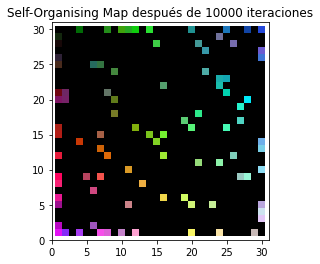

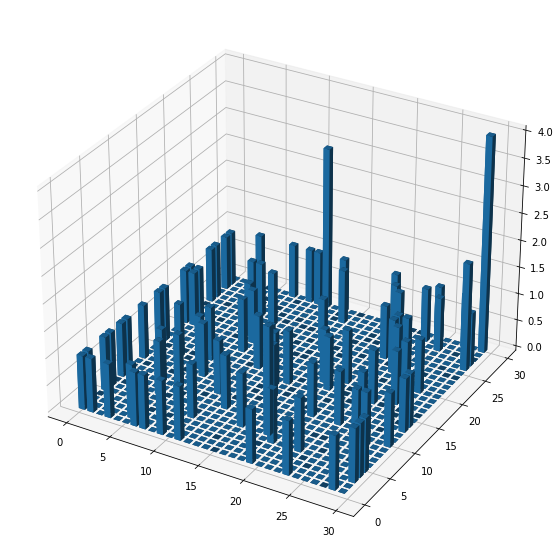

In [38]:
#pintar_mapa(mapa_activaciones)
cont += 1
pintar_mapa(mapa_clasificacion, cont)
#pintar_mapa(mapa_distancias)
# Agregar barra de colores
fig = plt.figure(figsize = (10,10))
hist = fig.add_subplot(111, projection='3d')


xpos = [range(mapa_activaciones.shape[0])] # El largo del eje x es igual a una lista que guarda el número de neuronas en el mapa de activación
ypos = [range(mapa_activaciones.shape[0])]
#print(ypos)
xpos, ypos = np.meshgrid(xpos, ypos) # Crea una matriz a partir de las listas creadas con anterioridad
#print(ypos)
xpos = xpos.flatten('F') # Pasa la matriz creada a una lista, la f indica que se hace por columnas de la matriz
ypos = ypos.flatten('F')
#print(ypos)
zpos = np.zeros_like(xpos) # Creamos una lista del mismo tamaño que x qe rellenaremos con los valores del mapa

dx = dy = 0.7 * np.ones_like(zpos) # Indicamos el grosor de las barras

dz = mapa_activaciones.flatten() # Damos el valor a la z con el del mapa de activaciones

#print(dz)

hist.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

## SOM Prueba

In [39]:
# Clasifica nuevos patrones
mapa_clasificacion_prueba = np.zeros(matriz_pesos.shape)
lista_colores = [[255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0]]
lista_colores = np.divide((lista_colores), (max(lista_colores))) 

print("BMU Activadas")
# Recorrer todo el dataset de prueba
for patron_entrada in lista_colores:
    # Calcular la BMU y sus coordenadas
    bmu, bmu_idx = calcular_bmu(patron_entrada, matriz_pesos, num_entradas)
    bmu_x, bmu_y = bmu_idx

    # Actualizar los mapas de clasificación, activaciones y distancias
    mapa_clasificacion_prueba[bmu_x, bmu_y] = patron_entrada      
    mapa_activaciones[bmu_x, bmu_y] += 1
    mapa_distancias[bmu_x, bmu_y] += np.mean(np.linalg.norm(patron_entrada - matriz_pesos[bmu_x, bmu_y]))
    
    print(bmu_idx)

# Calcular el número de clases en el dataset de prueba
num_clases_prueba = len(np.unique(mapa_clasificacion_prueba))

# Calcular el error de cuantificación en el dataset de prueba
error_cuantificacion_prueba = np.mean(np.linalg.norm(matriz_pesos - mapa_clasificacion_prueba, axis=2)) / num_entradas

# Calcular el error topológico en el dataset de prueba
error_topologico_prueba = 0
for x in range(lado_mapa):
    for y in range(lado_mapa):
        vecinos = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (i >= 0 and i < lado_mapa and j >= 0 and j < lado_mapa)]
        vecinos_activos = [v for v in vecinos if mapa_activaciones[v] > 0]
        if vecinos_activos:
            vecinos_distancias = [np.linalg.norm(matriz_pesos[x, y] - matriz_pesos[i, j]) for (i, j) in vecinos_activos]
        max_distancia = np.nanmax(vecinos_distancias)
        min_distancia = np.nanmin(vecinos_distancias)
        if min_distancia > 0:
            error_topologico += max_distancia / min_distancia

BMU Activadas
(29, 0)
(0, 12)
(12, 29)
(29, 29)
(14, 8)
(0, 0)
(27, 18)
(0, 28)


Mapa de clasificación


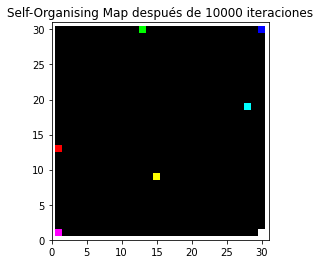

Mapa de activaciones (Histograma 3D)


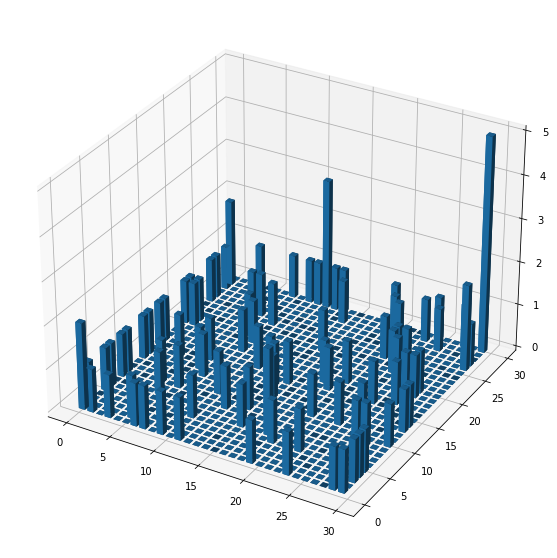

Mapa de distancias
[[0.62709948 0.14327214 0.         0.         0.21226085 0.12319252
  0.         0.15143252 0.23485561 0.         0.         0.13862398
  0.38876323 0.         0.14536936 0.13549178 0.         0.
  0.         0.19588904 0.21327235 0.         0.         0.
  0.07796686 0.12654982 0.         0.26203582 0.49654479 0.        ]
 [0.31144572 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.19307783 0.17768467 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.20549572 0.         0.         0. 

In [40]:
print("Mapa de clasificación")
cont += 1
pintar_mapa(mapa_clasificacion_prueba, cont)

print("Mapa de activaciones (Histograma 3D)")
fig = plt.figure(figsize = (10,10))
hist = fig.add_subplot(111, projection='3d')


xpos = [range(mapa_activaciones.shape[0])] # El largo del eje x es igual a una lista que guarda el número de neuronas en el mapa de activación
ypos = [range(mapa_activaciones.shape[0])]
#print(ypos)
xpos, ypos = np.meshgrid(xpos, ypos) # Crea una matriz a partir de las listas creadas con anterioridad
#print(ypos)
xpos = xpos.flatten('F') # Pasa la matriz creada a una lista, la f indica que se hace por columnas de la matriz
ypos = ypos.flatten('F')
#print(ypos)
zpos = np.zeros_like(xpos) # Creamos una lista del mismo tamaño que x qe rellenaremos con los valores del mapa

dx = dy = 0.7 * np.ones_like(zpos) # Indicamos el grosor de las barras

dz = mapa_activaciones.flatten() # Damos el valor a la z con el del mapa de activaciones

#print(dz)

hist.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

print("Mapa de distancias")
print(mapa_distancias)
print("Numero de clases en dataset de prueba: ", num_clases_prueba)
print("Error de cuantificación en dataset de prueba: ", error_cuantificacion_prueba)
print("Error de topologico en dataset de prueba: ", error_topologico_prueba)